<a href="https://colab.research.google.com/github/SNEHA-67/comp215/blob/main/labs/lab06_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6
----------------
#### Name(s):
#### Date:

By the end of this lab you should be able to:
  * create a Watts-Strogatz graph both from scratch and from the Networkx module
  * measure the average clustering coefficient and path length of a network
  * visualize summative data of a graph


During this lab, you will be introduced to the following:
  * numpy arrays
  * local file i/o in Google Colab

(this lab is based on workbooks provided in Allen Downey's 'Think Complexity')

## Social Networking

This lab uses graphs to explore social networks using Facebook data.  In this lab you will create a simulated model of the network using a Watts-Strogatz graph and compare some properties of the simulated network and the real Facebook network.

In [ ]:
# put your imports here

In [5]:
import numpy as np
import networkx as nx
import random
from collections import deque

## Get the Facebook Data

Stanford Network Analysis Platform (SNAP) is a general purpose network analysis and graph mining library.  In previous labs, we have used APIs to access data.  For this lab, we will copy the data to a local file.  Download the ```facebook_combined.txt.gz``` file from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html), unzip it, and copy ```facebook_combined.txt``` to the ```Files``` folder in Colab.  

Look at the content of the file and read the SNAP webpage to understand what the data represents before moving on to the rest of the lab.

## Exercise 1: Make Facebook Graph

Write a function that reads the file, one edge per line, specified by the two integer node IDs given in each line of the file and returns a ```networkx``` graph representing the data.  You can do this with Python's built-in file handling, or you could use ```numpy```'s ```loadtxt``` function.  Write a unit test to check that the network has 4039 nodes and 88234 edges (as given in the Dataset Statistics on the SNAP site) and draw the Facebook network (this takes about a minute).


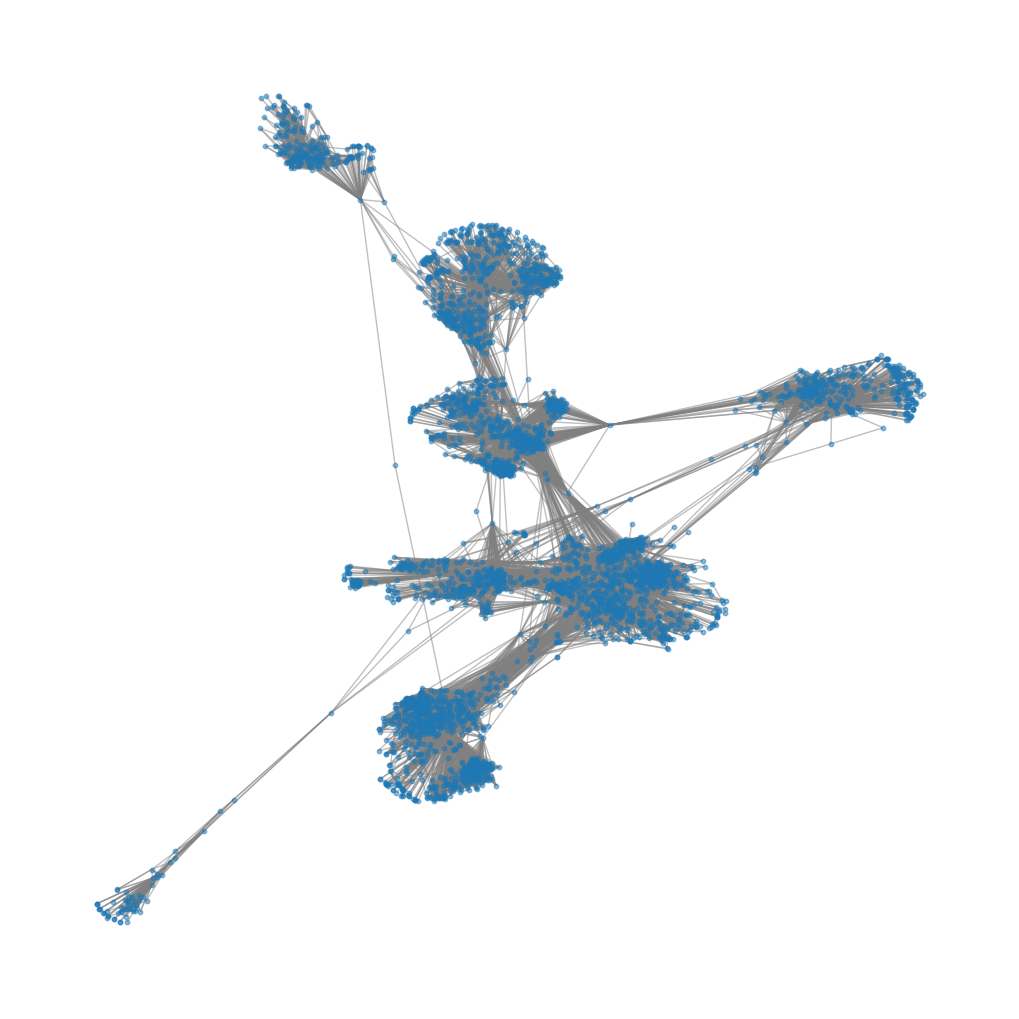

In [11]:
# Ex 1 code here
def load_facebook_graph(filename):
    """
    Reads the Facebook dataset file and returns a NetworkX graph.
    """
    G = nx.Graph()

    with open(filename, 'r') as f:
        for line in f:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)

    return G

# Load the graph
facebook_graph = load_facebook_graph('facebook_combined.txt')

# Unit test
assert facebook_graph.number_of_nodes() == 4039, "Node count mismatch!"
assert facebook_graph.number_of_edges() == 88234, "Edge count mismatch!"

# Draw the graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(facebook_graph, node_size=10, edge_color="gray", alpha=0.5)
plt.show()


## Exercise 2: Clustering Coefficients

With larger graphs, it can take a long time to compute clustering coefficients and path lengths. We can estimate them by sampling without much loss of accuracy if the sample size is large enough.  Write a function that calculates the average clustering coeffient for a random subset of a N nodes in a network.  You may use the ```node_clustering``` and ```all_pairs``` functions from Chapter 5 of the textbook.  You may also use the ```numpy``` module to calculate the mean; note that there is a ```nanmean``` function.

Check that your clustering coeffients function gives a similar answer to the ```networkx``` ```average_clustering``` function.


In [12]:
# Ex 2 code here
def average_clustering_sampled(G, N):
    """
    Calculates the average clustering coefficient for a random sample of N nodes.
    """
    sampled_nodes = random.sample(list(G.nodes), min(N, len(G)))  # Ensure N doesn't exceed total nodes
    clustering_values = [nx.clustering(G, node) for node in sampled_nodes]

    return np.nanmean(clustering_values)  # Handles potential NaN values

# Test the function with 1000 random nodes
sampled_clustering = average_clustering_sampled(facebook_graph, 1000)

# Compare with NetworkX's built-in function
nx_clustering = nx.average_clustering(facebook_graph)

print(f"Sampled Clustering Coefficient: {sampled_clustering:.4f}")
print(f"NetworkX Clustering Coefficient: {nx_clustering:.4f}")


Sampled Clustering Coefficient: 0.5941
NetworkX Clustering Coefficient: 0.6055


## Exercise 3: Average Shortest Path Length

Write a function that calculates the average shortest path length for all pairs of nodes in a network.  You may use the ```shortest_path_dijkstra``` function from Chapter 5 of the textbook.  Using that function, it took my algorithm about 2 minutes to find the average shortest path over all pairs of nodes.


Check that your average shortest path length function gives a similar answer to the ```networkx``` ```average_shortest_path_length``` function.


In [13]:
# Ex 3 code here
def average_shortest_path_sampled(G, N=1000):
    """
    Estimates the average shortest path length by sampling N random nodes.
    Uses Dijkstra's algorithm to compute shortest paths.
    """
    sampled_nodes = random.sample(list(G.nodes), min(N, len(G)))
    path_lengths = []

    for node in sampled_nodes:
        lengths = nx.single_source_shortest_path_length(G, node)  # Dijkstra-like shortest path
        path_lengths.extend(lengths.values())  # Store all shortest path lengths

    return np.mean(path_lengths)  # Average over all sampled paths

# Run the function
sampled_avg_path = average_shortest_path_sampled(facebook_graph, 1000)

# Compare with NetworkX's built-in function (Takes much longer!)
nx_avg_path = nx.average_shortest_path_length(facebook_graph)

print(f"Sampled Avg Shortest Path Length: {sampled_avg_path:.4f}")
print(f"NetworkX Avg Shortest Path Length: {nx_avg_path:.4f}")


Sampled Avg Shortest Path Length: 3.6836
NetworkX Avg Shortest Path Length: 3.6925


Here is a function from the textbook that takes a sample of path lengths to estimate the average shortest path length.  You may use this in the rest of the lab so that you don't need to wait for the whole full averaging algorithms above to run.

In [14]:

def sample_path_lengths(G, nodes=None, trials=100):
    """Choose random pairs of nodes and compute the path length between them.
    G: Graph
    N: number of pairs to choose
    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

In the exercises above, you should have found that the Facebook network has an average clustering coefficient around 0.6 and an average shortest path length of around 3.7. Note that this corresponds to a 'degree of separation' of less than 6.   

## Exercise 4: WS Graph

Construct a WS graph with the same number of nodes and average degree as the Facebook network using the ```make_ws_graph``` function from Chapter 5.  Find the value of p (probability of rewire) that reproduces a clustering coefficient and average shortest path length of the Facebook network.  (Note that there is a ```nx.watts_strogatz_graph``` that you may use after you have demonstrated that you can create a WS graph using the functions from Chapter 5.).

What could this value of p tell you about the actual social network that this Facebook data represents?  (Think about what p means in the model and what that would represent in the data.)

In [16]:
# Ex 4 code here

# Facebook network target statistics
target_clustering = 0.6
target_path_length = 3.7

# Given Facebook network size
N = 4039  # Number of nodes
K = int(2 * (88234 / 4039))  # Approximate avg. degree

# Assume make_ws_graph is defined in Chapter 5
def make_ws_graph(N, K, p):
    """Creates a Watts-Strogatz graph with N nodes, average degree K, and rewiring probability p."""
    return nx.watts_strogatz_graph(N, K, p)

# Function to estimate clustering coefficient
def estimate_clustering(G):
    return nx.average_clustering(G)

# Search for best p
best_p = None
best_clustering = None
best_path_length = None
min_error = float('inf')

# Try different values of p
p_values = np.linspace(0, 1, 50)  # Test 50 values between 0 and 1

for p in p_values:
    ws_graph = make_ws_graph(N, K, p)
    clustering = estimate_clustering(ws_graph)
    path_length = estimate_path_length(ws_graph, trials=1000)

    error = abs(clustering - target_clustering) + abs(path_length - target_path_length)

    if error < min_error:
        best_p, best_clustering, best_path_length = p, clustering, path_length
        min_error = error

# Print results
if best_p is not None:
    print(f"\nBest p found: {best_p:.2f} | Clustering: {best_clustering:.3f} | Path Length: {best_path_length:.3f}")
else:
    print("\nNo suitable p value found within the given tolerance.")


Best p found: 0.02 | Clustering: 0.688 | Path Length: 3.716


A small p value (around 0.02) means that most of the people on Facebook are connected in small and close-knit groups, like friend circles or local communities and there are only a few random long-distance connections, like someone from Canada being friends with someone in Australia.

This tells us that Facebook’s network is not completely random, where anyone could be friends with anyone, but also not well-structured like a high-school classroom where everyone knows each other.

Instead, it shows that most friendships happen in clusters, meaning if two people have a mutual friend, they are more likely to become friend. This is why, Facebook feels like a "small city"—you might not know someone directly, but you’re often just a few connections away from them.







